In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import itertools
import warnings
import numpy as np

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/PTDLKD/Data/Gold_Data.csv", index_col='Date')

In [ ]:
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
05/19/2023,"1,978.70","1,960.00","1,976.70","1,960.00",0.11K,1.13%
05/18/2023,"1,956.50","1,956.80","1,956.80","1,956.80",0.02K,-1.22%
05/17/2023,"1,980.70","1,983.60","1,983.60","1,983.60",0.01K,-0.39%
05/16/2023,"1,988.40","2,021.30","2,022.70","1,989.10",0.05K,-1.47%
05/15/2023,"2,018.00","2,013.80","2,017.10","2,013.80",0.00K,-0.09%
...,...,...,...,...,...,...
05/25/2018,"1,303.70","1,304.00","1,307.20","1,299.40",292.91K,-0.05%
05/24/2018,"1,304.40","1,293.30","1,306.40","1,292.20",432.42K,1.15%
05/23/2018,"1,289.60","1,290.60","1,298.40","1,286.70",402.34K,-0.19%



# Preprocessing Data

---





In [ ]:
# Drop column that aren't use
df.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis = 1, inplace=True)

# Drop missing values
df = df.dropna()

# Flip the column
df = df.iloc[::-1]

In [ ]:
# Check if data still contain null values
df.isnull().sum()

Price    0
dtype: int64

In [ ]:
# Format column Date
df.index = pd.to_datetime(df.index,format='%m/%d/%Y')

# Format column Price to float
df['Price'] = df.Price.str.replace(',','').astype(float)

In [ ]:
df

,Price
Date,
2018-05-21,1290.9
2018-05-22,1292.0
2018-05-23,1289.6
2018-05-24,1304.4
2018-05-25,1303.7
...,...
2023-05-15,2018.0
2023-05-16,1988.4
2023-05-17,1980.7


In [ ]:
# Get the last date in the 'Date' column
last_date = df.index[-1]

# Create a new column with the next 30 days
next_30_days = pd.date_range(start=last_date + datetime.timedelta(days=1), periods=30)

# Create next 30 days dataframe
forecast_df = pd.DataFrame(index=next_30_days)
forecast_df.index.name = "Date"

# Decompose

---



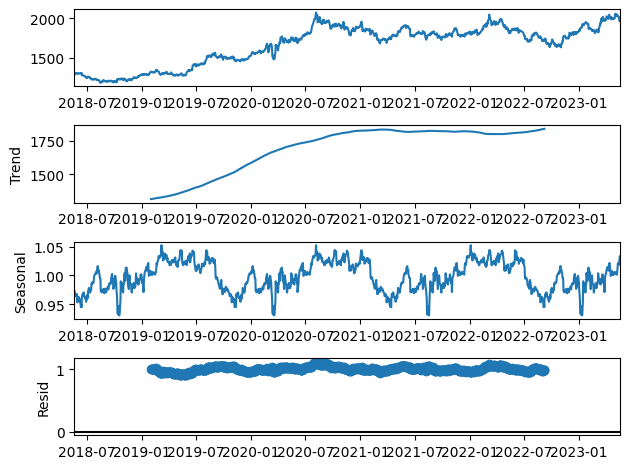

In [ ]:
# Perform seasonal decomposition on the resampled dataframe using a multiplicative model and a period of  (day)
decompose = df
decompose_result = seasonal_decompose(decompose,model='mul', period=365)
decompose_result.plot();

# Split dataset (7-2-1)

---



In [ ]:
# Calculate the accuracy of each model
def evaluateModel(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_value = test.Price.values
  pred_value = pred.values
  test_ape = np.abs((test_value - pred_value) / test_value)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)
  
  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val.tail(len(val)))
  print('MAE: ', val_mae)

  val_value = val.Price.values
  pred_val_value = pred_val.tail(len(val)).values
  val_ape = np.abs((val_value - pred_val_value) / val_value)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val.tail(len(val)))
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [ ]:
# Spilit data (7-2-1)
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train = df[:train_size]
test = df[train_size:train_size+test_size]
val = df[train_size+test_size:]

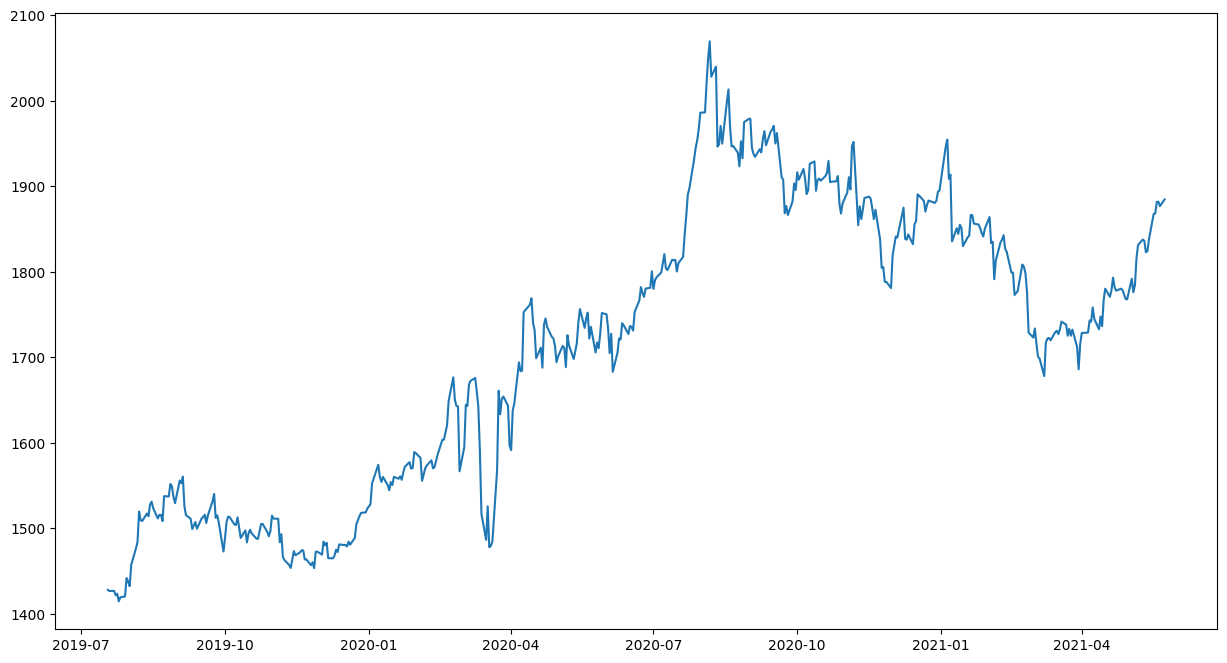

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[300:777], train['Price'][300:777]);

In [ ]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=410, damped_trend=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df) + len(val)) 
pred_val = fit.forecast(len(val) + len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


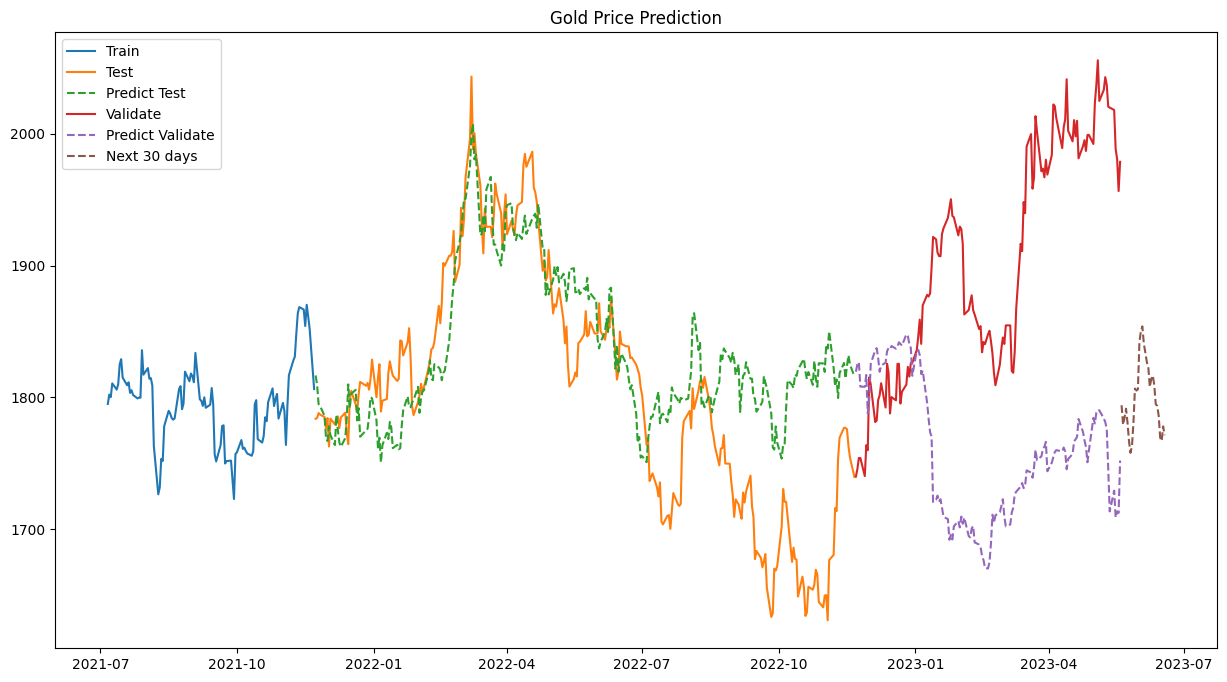

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[train_size - 100:], train['Price'][train_size - 100:], label="Train");
# ax.plot(train.index, train['Price'], label="Train");
ax.plot(test.index, test['Price'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(val.index, val, label="Validate")
ax.plot(val.index, pred_val.tail(len(val)), linestyle='--', label="Predict Validate")
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("Gold Price Prediction");

In [ ]:
evaluateModel(test, pred, val, pred_val)

** Testing **
MAE:  51.69577891632318
MAPE:  2.9651037915666536
RMSE:  69.43998875099453

** Validate **
MAE:  159.28222115363673
MAPE:  8.20754147390137
RMSE:  181.83550697768786


In [ ]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Price   No. Observations:                  907
Model:             ExponentialSmoothing   SSE                         148203.245
Optimized:                         True   AIC                           5452.251
Trend:                   Multiplicative   BIC                           7448.460
Seasonal:                Multiplicative   AICC                          6165.159
Seasonal Periods:                   410   Date:                 Fri, 09 Jun 2023
Box-Cox:                          False   Time:                         12:46:28
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.8535677                alpha                 True
smoothing_trend       

# Split dataset (6-3-1)

---

In [ ]:
# Spilit data (6-3-1)
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train = df[:train_size]
test = df[train_size:train_size+test_size]
val = df[train_size+test_size:]

In [ ]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
# holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=380, damped_trend=True)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=351, damped_trend=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df) + len(val)) 
pred_val = fit.forecast(len(val) + len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


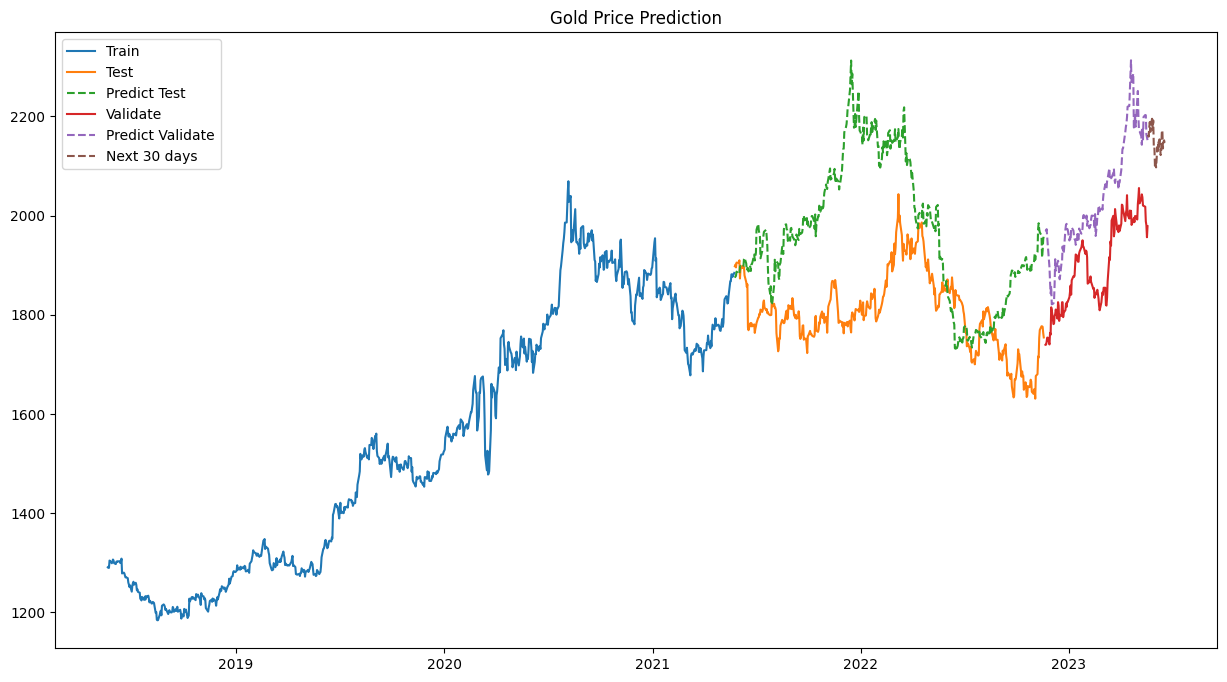

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
# ax.plot(train.index[train_size - 100:], train['Price'][train_size - 100:], label="Train");
ax.plot(train.index, train['Price'], label="Train");
ax.plot(test.index, test['Price'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(val.index, val, label="Validate")
ax.plot(val.index, pred_val.tail(len(val)), linestyle='--', label="Predict Validate")
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("Gold Price Prediction");

In [ ]:
evaluateModel(test, pred, val, pred_val)

** Testing **
MAE:  169.95692448785564
MAPE:  9.475619835125581
RMSE:  205.02351316515973

** Validate **
MAE:  134.08798944868886
MAPE:  7.059451050129351
RMSE:  148.69481262817388


In [ ]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Price   No. Observations:                  777
Model:             ExponentialSmoothing   SSE                         129036.376
Optimized:                         True   AIC                           4684.342
Trend:                   Multiplicative   BIC                           6341.679
Seasonal:                Multiplicative   AICC                          5299.280
Seasonal Periods:                   351   Date:                 Fri, 09 Jun 2023
Box-Cox:                          False   Time:                         12:46:42
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9596371                alpha                 True
smoothing_trend       

# Split Dataset (5-3-2)

---



In [ ]:
# Spilit data (5-3-2)
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train = df[:train_size]
test = df[train_size:train_size+test_size]
val = df[train_size+test_size:]

In [ ]:
train

,Price
Date,
2018-05-21,1290.9
2018-05-22,1292.0
2018-05-23,1289.6
2018-05-24,1304.4
2018-05-25,1303.7
...,...
2020-11-13,1886.2
2020-11-16,1887.8
2020-11-17,1885.1


In [ ]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
# holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=380, damped_trend=True)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=293, damped_trend=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df) + len(val)) 
pred_val = fit.forecast(len(val) + len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


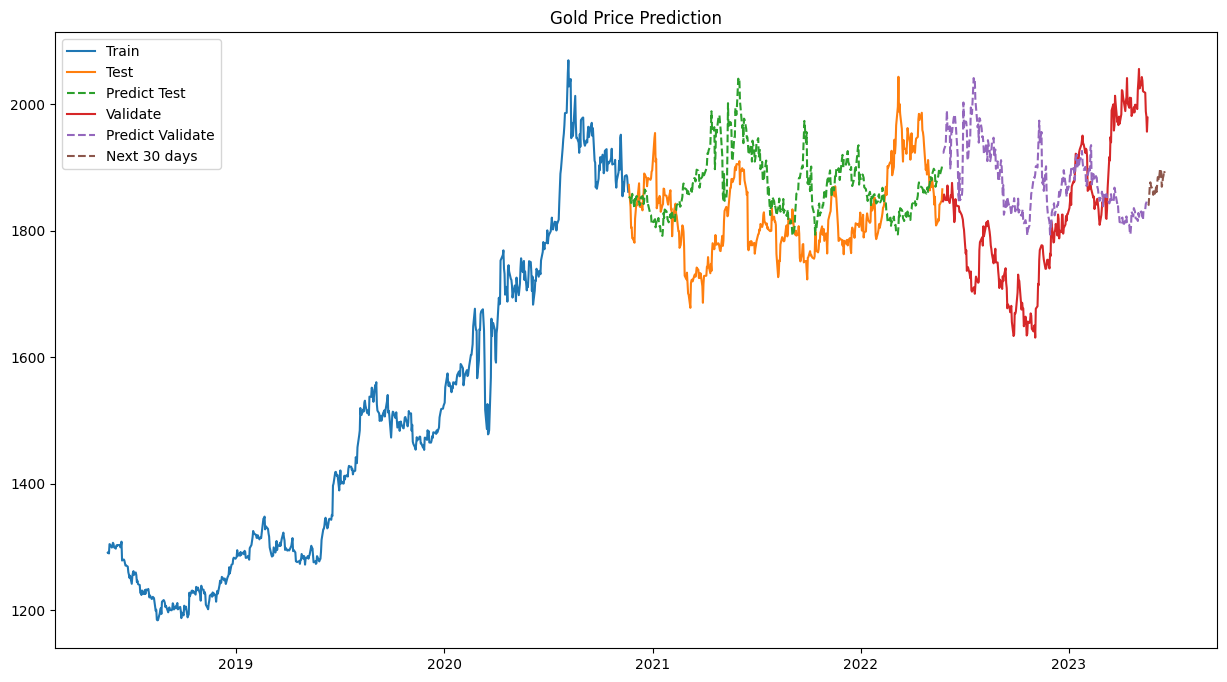

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
# ax.plot(train.index[train_size - 100:], train['Price'][train_size - 100:], label="Train");
ax.plot(train.index, train['Price'], label="Train");
ax.plot(test.index, test['Price'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(val.index, val, label="Validate")
ax.plot(val.index, pred_val.tail(len(val)), linestyle='--', label="Predict Validate")
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("Gold Price Prediction");

In [ ]:
evaluateModel(test, pred, val, pred_val)

** Testing **
MAE:  82.63000918787937
MAPE:  4.560056111207467
RMSE:  99.18278082890166

** Validate **
MAE:  122.29090176007999
MAPE:  6.793387799446126
RMSE:  143.7450394913242


In [ ]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Price   No. Observations:                  648
Model:             ExponentialSmoothing   SSE                         107072.542
Optimized:                         True   AIC                           3905.577
Trend:                   Multiplicative   BIC                           5238.796
Seasonal:                Multiplicative   AICC                          4426.038
Seasonal Periods:                   293   Date:                 Fri, 09 Jun 2023
Box-Cox:                          False   Time:                         12:46:52
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9242805                alpha                 True
smoothing_trend       

# Evaluating Model

---
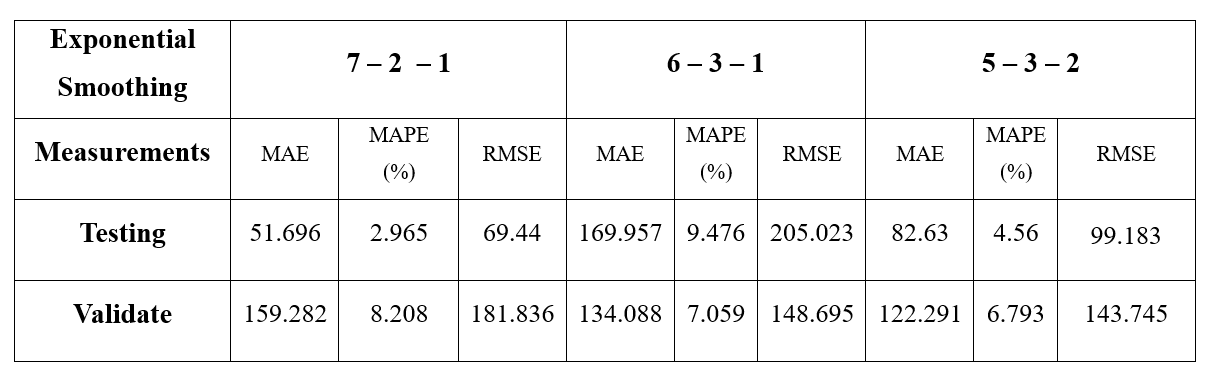
